In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Libraries specifically for time-series analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Memasukan data 
df = pd.read_json('Polybags_datas_updated.json')
greenhouse_data = pd.read_json('Greenhouse_datas_updated.json')
polybags_data = pd.read_json('Polybags.json')

In [3]:
# Melihat dataset 2 teratas
df.head(2)

,polybagDataId,ownedPolybag,dayAfterPlanted,ec,n,p,k,ph,createdAt,updatedAt
0,1,1,1,1.094934,24.27,12.95,34.22,6.53,2024-01-01 00:00:00,2024-01-01 00:00:00
1,2,1,1,1.272122,11.31,6.17,23.65,5.55,2024-01-01 04:48:00,2024-01-01 04:48:00


In [4]:
# Melihat dataset 2 terbawah
df.tail(2)
greenhouse_data.tail(2)

,greenhouseDataId,ownedGreenhouse,airTemperature,humidity,ec,ph,ppm,volumeWaterTank,countWaterFlow,createdAt,updatedAt
2248,2249,1,26.422329,64.313349,1.105657,5.766007,630.093865,129.006883,52.1,2024-03-30 12:00:00,2024-03-30 12:00:00
2249,2250,1,29.147625,73.766427,1.127357,6.662992,479.398620,92.559841,98.0,2024-03-30 16:00:00,2024-03-30 16:00:00


In [5]:
df.columns

Index(['polybagDataId', 'ownedPolybag', 'dayAfterPlanted', 'ec', 'n', 'p', 'k',
       'ph', 'createdAt', 'updatedAt'],
      dtype='object')

In [6]:
# Transform data untuk memudahkan membaca dan menganalisa kolom dari data
df.head(2).T

,0,1
polybagDataId,1,2
ownedPolybag,1,1
dayAfterPlanted,1,1
ec,1.094934,1.272122
n,24.27,11.31
p,12.95,6.17
k,34.22,23.65
ph,6.53,5.55
createdAt,2024-01-01 00:00:00,2024-01-01 04:48:00
updatedAt,2024-01-01 00:00:00,2024-01-01 04:48:00


In [7]:
# Memilih kolom 'airTemperature' dari DataFrame greenhouse_data
airTemperature = greenhouse_data[['airTemperature']]

In [8]:
# Memilih kolom 'humidity' dari DataFrame greenhouse_data
humidity = greenhouse_data[['humidity']]

In [9]:
# Memilih kolom 'weightOfHarvest' dari DataFrame polybags
weightOfHarvest = polybags_data[['weightOfHarvest']]

In [10]:
# Menggabungkan kolom 'airTemperature' ke DataFrame polybags_data
df = pd.concat([df, airTemperature], axis=1)

In [11]:
# Menggabungkan kolom 'humidity' ke DataFrame polybags_data
df = pd.concat([df, humidity], axis=1)

In [12]:
# Menggabungkan kolom 'weightOfHarvest' ke DataFrame polybags_data
df = pd.concat([df, weightOfHarvest], axis=1)

In [13]:
df = df.replace(np.nan, 0)

In [14]:
# Menampilkan DataFrame hasil gabungan
df.head(2)

,polybagDataId,ownedPolybag,dayAfterPlanted,ec,n,p,k,ph,createdAt,updatedAt,airTemperature,humidity,weightOfHarvest
0,1,1,1,1.094934,24.27,12.95,34.22,6.53,2024-01-01 00:00:00,2024-01-01 00:00:00,32.409242,47.15,1231.304263
1,2,1,1,1.272122,11.31,6.17,23.65,5.55,2024-01-01 04:48:00,2024-01-01 04:48:00,31.898002,43.87,2399.163405


In [15]:
# Tambahkan kolom "season" dengan kondisi yang ditentukan
df['season'] = df['airTemperature'].apply(lambda x: 1 if 20 <= x <= 27 else (0 if 28 <= x <= 35 else None))

# Misalkan threshold untuk berat buah melon yang bagus adalah 1500 gram ( '1' = Good, '0' = Not Good)
df['weightCategory'] = df['weightOfHarvest'].apply(lambda x: 1 if x >= 1500 else 0)

In [16]:
# Menampilkan DataFrame hasil gabungan
df.head(10)

,polybagDataId,ownedPolybag,dayAfterPlanted,ec,n,p,k,ph,createdAt,updatedAt,airTemperature,humidity,weightOfHarvest,season,weightCategory
0,1,1,1,1.094934,24.27,12.95,34.22,6.53,2024-01-01 00:00:00,2024-01-01 00:00:00,32.409242,47.15,1231.304263,0.0,0
1,2,1,1,1.272122,11.31,6.17,23.65,5.55,2024-01-01 04:48:00,2024-01-01 04:48:00,31.898002,43.87,2399.163405,0.0,1
2,3,1,1,1.871176,13.35,12.97,31.55,5.84,2024-01-01 09:36:00,2024-01-01 09:36:00,28.723906,54.78,1705.458217,0.0,1
3,4,1,1,1.304287,22.66,7.09,24.98,6.40,2024-01-01 14:24:00,2024-01-01 14:24:00,29.258810,37.79,2406.306161,0.0,1
4,5,1,1,1.453996,14.96,6.59,23.67,6.96,2024-01-01 19:12:00,2024-01-01 19:12:00,33.086013,89.61,1884.746456,0.0,1
5,6,2,1,1.994467,25.77,12.96,26.50,6.09,2024-01-01 00:00:00,2024-01-01 00:00:00,28.702618,50.35,0.000000,0.0,0
6,7,2,1,1.692206,16.27,8.45,27.15,6.16,2024-01-01 04:48:00,2024-01-01 04:48:00,32.811471,87.32,0.000000,0.0,0
7,8,2,1,1.706147,27.01,14.88,27.72,6.03,2024-01-01 09:36:00,2024-01-01 09:36:00,34.763891,62.83,0.000000,0.0,0
8,9,2,1,1.127615,25.13,12.57,30.42,6.81,2024-01-01 14:24:00,2024-01-01 14:24:00,31.801364,64.85,0.000000,0.0,0
9,10,2,1,1.181252,14.46,9.53,23.76,5.58,2024-01-01 19:12:00,2024-01-01 19:12:00,34.801986,87.85,0.000000,0.0,0


In [17]:
#Season value '1' = rainySeason
#Season value '0' = drySeason

In [18]:
# Melihat ukuran dari dataset
df.shape

(2250, 15)

In [19]:
df

,polybagDataId,ownedPolybag,dayAfterPlanted,ec,n,p,k,ph,createdAt,updatedAt,airTemperature,humidity,weightOfHarvest,season,weightCategory
0,1,1,1,1.094934,24.27,12.95,34.22,6.53,2024-01-01 00:00:00,2024-01-01 00:00:00,32.409242,47.150000,1231.304263,0.0,0
1,2,1,1,1.272122,11.31,6.17,23.65,5.55,2024-01-01 04:48:00,2024-01-01 04:48:00,31.898002,43.870000,2399.163405,0.0,1
2,3,1,1,1.871176,13.35,12.97,31.55,5.84,2024-01-01 09:36:00,2024-01-01 09:36:00,28.723906,54.780000,1705.458217,0.0,1
3,4,1,1,1.304287,22.66,7.09,24.98,6.40,2024-01-01 14:24:00,2024-01-01 14:24:00,29.258810,37.790000,2406.306161,0.0,1
4,5,1,1,1.453996,14.96,6.59,23.67,6.96,2024-01-01 19:12:00,2024-01-01 19:12:00,33.086013,89.610000,1884.746456,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,2246,5,90,2.460971,11.50,5.75,21.25,5.50,2024-03-30 00:00:00,2024-03-30 00:00:00,25.812120,81.508246,0.000000,1.0,0
2246,2247,5,90,1.150000,14.50,7.25,23.75,5.70,2024-03-30 04:00:00,2024-03-30 04:00:00,27.297493,74.090263,0.000000,NaN,0
2247,2248,5,90,1.250000,17.50,8.75,26.25,5.50,2024-03-30 08:00:00,2024-03-30 08:00:00,22.973180,50.935156,0.000000,1.0,0
2248,2249,5,90,1.350000,20.50,10.25,28.75,5.70,2024-03-30 12:00:00,2024-03-30 12:00:00,26.422329,64.313349,0.000000,1.0,0


In [20]:
# Melihat season dengan nilai 1 yang artinya itu rainySeason
df[df['season']==1]

,polybagDataId,ownedPolybag,dayAfterPlanted,ec,n,p,k,ph,createdAt,updatedAt,airTemperature,humidity,weightOfHarvest,season,weightCategory
1101,1102,1,45,1.290000,12.38,6.25,15.78,5.99,2024-02-14 04:48:00,2024-02-14 04:48:00,25.250000,67.300000,0.0,1.0,0
1103,1104,1,45,1.620000,15.39,7.76,29.36,6.89,2024-02-14 14:24:00,2024-02-14 14:24:00,26.050000,58.940000,0.0,1.0,0
1109,1110,2,45,2.140000,19.45,6.56,31.98,6.53,2024-02-14 19:12:00,2024-02-14 19:12:00,26.750000,59.420000,0.0,1.0,0
1112,1113,3,45,1.500000,27.13,12.23,19.47,6.26,2024-02-14 09:36:00,2024-02-14 09:36:00,25.300000,61.000000,0.0,1.0,0
1114,1115,3,45,1.500000,24.49,12.53,33.12,5.94,2024-02-14 19:12:00,2024-02-14 19:12:00,25.450000,70.060000,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,2242,4,90,1.150000,14.50,7.25,23.75,5.70,2024-03-30 04:00:00,2024-03-30 04:00:00,26.925237,62.538957,0.0,1.0,0
2244,2245,4,90,1.450000,23.50,11.75,31.25,5.50,2024-03-30 16:00:00,2024-03-30 16:00:00,25.317072,68.303844,0.0,1.0,0
2245,2246,5,90,2.460971,11.50,5.75,21.25,5.50,2024-03-30 00:00:00,2024-03-30 00:00:00,25.812120,81.508246,0.0,1.0,0
2247,2248,5,90,1.250000,17.50,8.75,26.25,5.50,2024-03-30 08:00:00,2024-03-30 08:00:00,22.973180,50.935156,0.0,1.0,0


In [21]:
df.drop(labels=['updatedAt'], axis=1, inplace=True)

In [22]:
# Langkah 1: Persiapan Data
# Mengkonversi kolom 'createdAt' ke datetime
df['createdAt'] = pd.to_datetime(df['createdAt'])

# Menghapus duplikat pada kolom 'createdAt'
df = df.drop_duplicates(subset=['createdAt'])

# Mengatur 'createdAt' sebagai indeks
df.set_index('createdAt', inplace=True)
df = df.asfreq('D')

# Mengambil data EC
ec_data = df['ec']
temperature_data = df['airTemperature']


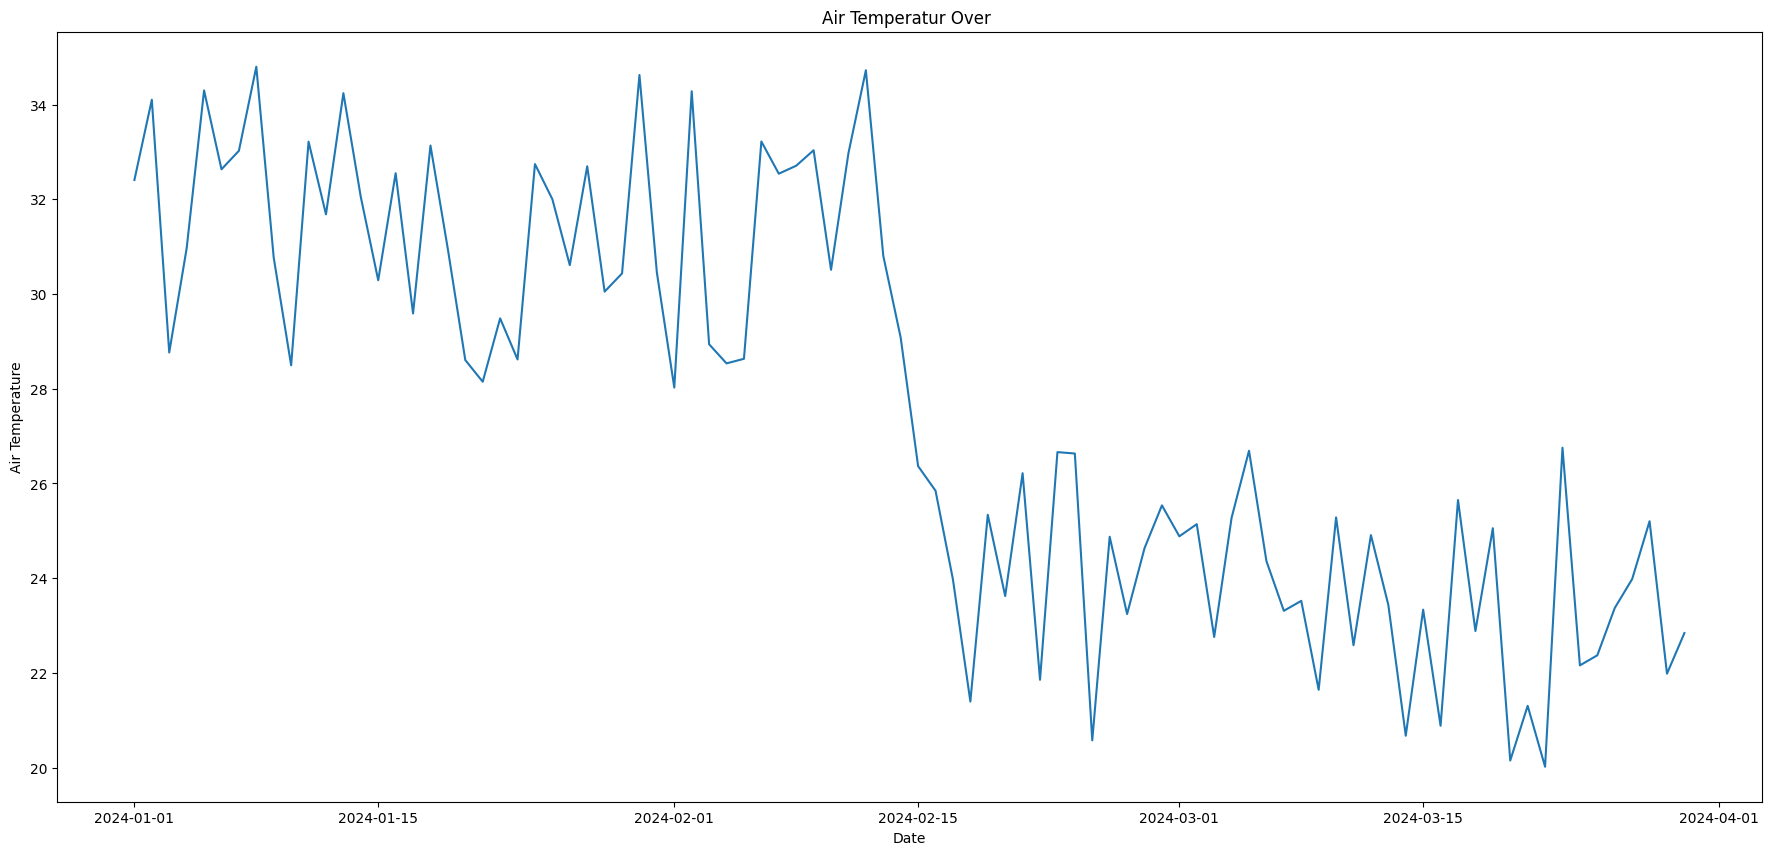

In [23]:
plt.figure(figsize=(22,10))
plt.plot(temperature_data, label='Air Temperature')
plt.title("Air Temperatur Over ")
plt.xlabel("Date")
plt.ylabel("Air Temperature")
plt.show()

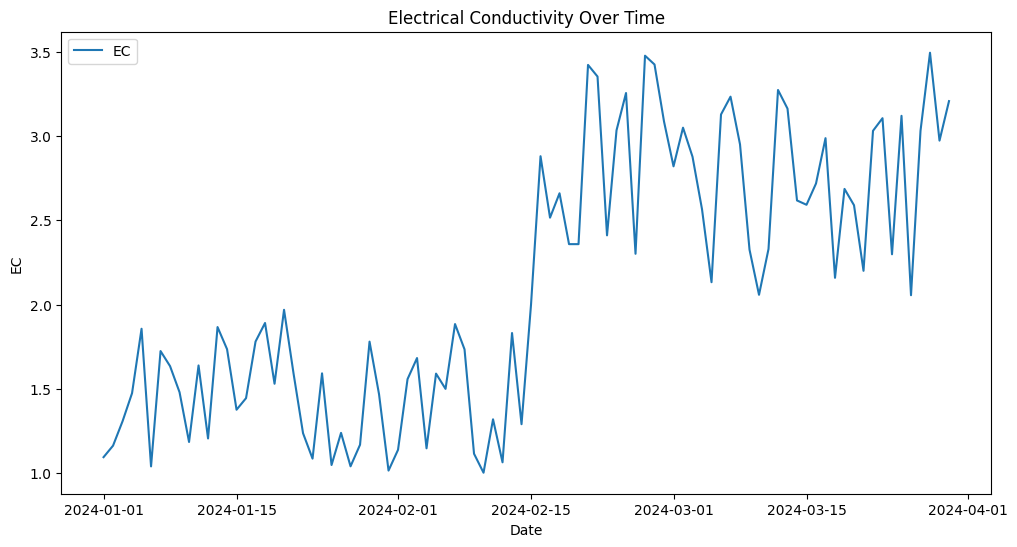

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(ec_data, label='EC')
plt.title('Electrical Conductivity Over Time')
plt.xlabel('Date')
plt.ylabel('EC')
plt.legend()
plt.show()

In [25]:
# Langkah 2: Pemeriksaan Stasioneritas
# Melakukan uji ADF untuk memeriksa stasioneritas
result = adfuller(ec_data.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.7333097916210489
p-value: 0.8379318901963251


In [26]:
ec_data_diff = ec_data.diff().dropna()

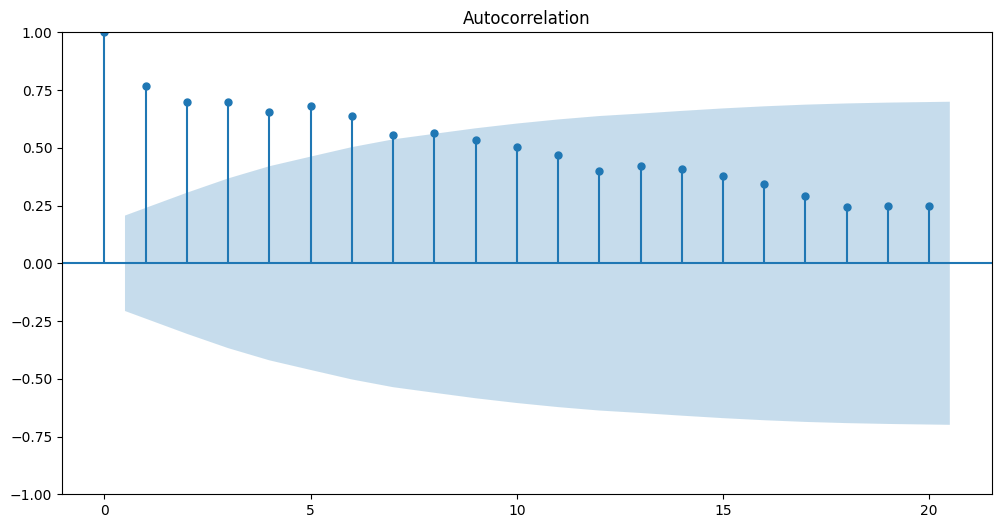

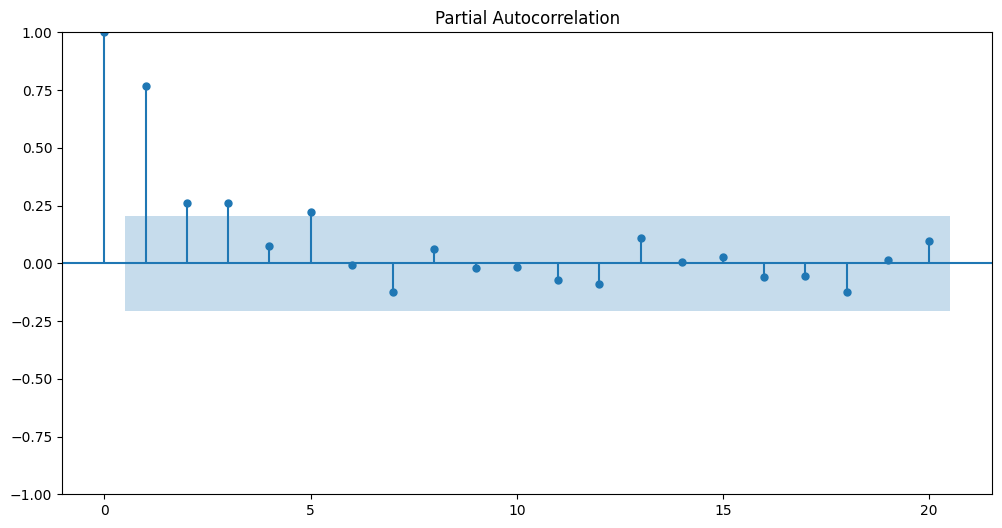

In [27]:
# Langkah 3: Plot ACF dan PACF
# Plot ACF dan PACF untuk memahami pola dalam data
plt.figure(figsize=(12, 6))
plot_acf(ec_data.dropna(), ax=plt.gca())
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(ec_data.dropna(), ax=plt.gca())
plt.show()

In [28]:
# Langkah 4: Mencari Parameter SARIMA Terbaik
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(0, 0, 0, 7), (1, 0, 0, 7), (0, 1, 0, 7), (0, 0, 1, 7)]

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(ec_data, order=param, seasonal_order=seasonal_param)
            results = model.fit(disp=False, maxiter=100)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
        except Exception as e:
            continue

print(f'Best SARIMA{best_pdq}x{best_seasonal_pdq} AIC:{best_aic}')


Best SARIMA(0, 1, 1)x(1, 0, 0, 7) AIC:105.49313473926202


In [29]:
# Langkah 5: Fit model SARIMA terbaik pada seluruh dataset
model = SARIMAX(
    ec_data, 
    order=best_pdq, 
    seasonal_order=best_seasonal_pdq,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False, maxiter=500, cov_type='robust')
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ec   No. Observations:                   90
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood                 -47.080
Date:                            Fri, 19 Jul 2024   AIC                            100.159
Time:                                    07:23:02   BIC                            107.379
Sample:                                01-01-2024   HQIC                           103.058
                                     - 03-30-2024                                         
Covariance Type:                           robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5888      0.100     -5.872      0.000      -0.785      -0.392
ar.S.L7       -0.2071      0.122   

In [30]:
# Menyimpan model yang telah dilatih
timeseries_result = 'sarima_model.pkl'
joblib.dump(results, timeseries_result)

print(f"Model telah disimpan sebagai '{timeseries_result}'")

Model telah disimpan sebagai 'sarima_model.pkl'


In [31]:
# Langkah 6: Forecast untuk 7 hari ke depan
forecast_steps = 7
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [32]:
# Mengonversi indeks menjadi rentang tanggal yang sesuai untuk plotting
forecast_index = pd.date_range(start=ec_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

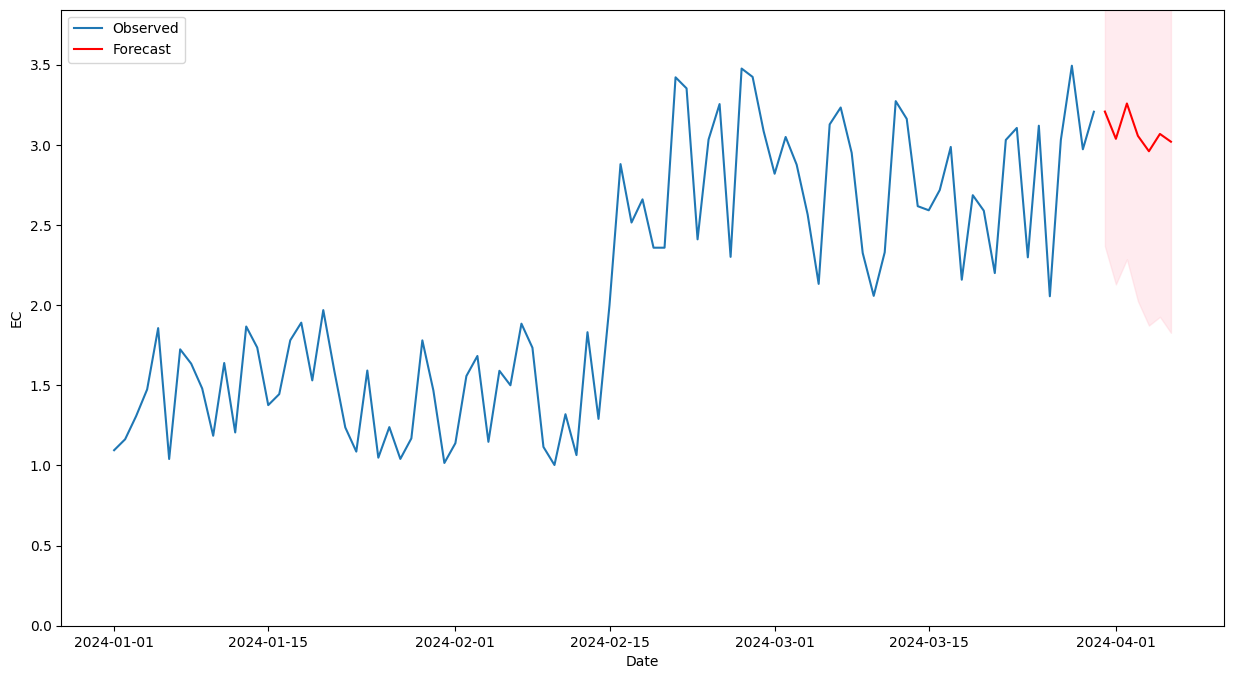

In [33]:
# Langkah 7: Membuat plot/visual hasil peramalan
plt.figure(figsize=(15, 8))
plt.plot(ec_data.index, ec_data, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('EC')
plt.legend()
plt.ylim(0, ec_data.max() * 1.1)  # Menyesuaikan batas sumbu y ke skala normal

plt.show()

In [34]:
# Menampilkan hasil peramalan 7 hari dalam bentuk list
forecast_result = forecast_mean.tolist()
print("Hasil peramalan untuk 7 hari ke depan:")
for i, value in enumerate(forecast_result, start=1):
    print(f"Hari {i}: {value}")

Hasil peramalan untuk 7 hari ke depan:
Hari 1: 3.2077242079494566
Hari 2: 3.0376283701578797
Hari 3: 3.2580247253715813
Hari 4: 3.0560305556059726
Hari 5: 2.9601140900020044
Hari 6: 3.068107276181908
Hari 7: 3.0195648328636846


In [35]:
# Memisahkan data menjadi set pelatihan dan pengujian
train_size = int(len(ec_data) * 0.8)
train_data, test_data = ec_data[:train_size], ec_data[train_size:]

In [36]:
# Menyesuaikan model SARIMA pada set pelatihan
model = SARIMAX(
    train_data, 
    order=best_pdq, 
    seasonal_order=best_seasonal_pdq,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False, maxiter=500, cov_type='robust')

# Melakukan peramalan untuk periode pengujian
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

In [37]:
# Menghitung metrik evaluasi
mae = mean_absolute_error(test_data, forecast_mean)
mse = mean_squared_error(test_data, forecast_mean)
rmse = np.sqrt(mse)

print('Evaluasi Akurasi pada Data Train')
print('Nilai Mean Absolute Error (MAE) : ', mae)
print('Nilai Mean Squared Error (MSE) : ', mse)
print('Nilai Root Mean Squared Error (RMSE) : ', rmse)

Evaluasi Akurasi pada Data Train
Nilai Mean Absolute Error (MAE) :  0.3485231218873573
Nilai Mean Squared Error (MSE) :  0.1729853759822969
Nilai Root Mean Squared Error (RMSE) :  0.41591510670123166


In [38]:
#Nilai MAE, MSE, dan RMSE yang rendah dan mendekati 0 menunjukkan bahwa prediksi sudah cukup akurat

In [39]:
# Extracting the weightOfHarvest column data
weight_of_harvest = polybags_data['weightOfHarvest'].tolist()

# Repeating weight_of_harvest to match the length of forecast_result if necessary
matched_weights_result = []
weight_of_harvest_length = len(weight_of_harvest)

for i in range(len(forecast_result)):
    matched_weights_result.append(weight_of_harvest[i % weight_of_harvest_length])

# Creating a new DataFrame with forecast results and the corresponding weights
forecast_df_result = pd.DataFrame({
    'Forecasted EC': forecast_result,
    'WeightOfHarvest': matched_weights_result
})

In [40]:
forecast_df_result.head(10)

,Forecasted EC,WeightOfHarvest
0,3.207724,1231.304263
1,3.037628,2399.163405
2,3.258025,1705.458217
3,3.056031,2406.306161
4,2.960114,1884.746456
5,3.068107,1231.304263
6,3.019565,2399.163405
